In [1]:
# let's test how much subset error varies in a small set of galaxies in the "all-fixed" case
# let's test 10

In [2]:
import os

os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["JAX_ENABLE_X64"] = "True"


In [3]:
from functools import partial
from pathlib import Path

import jax.numpy as jnp
import typer
from jax import jit, random, vmap

from bpd import DATA_DIR
from bpd.io import load_dataset_jax, save_dataset
from bpd.pipelines import pipeline_shear_inference
from bpd.prior import interim_gprops_logprior, true_all_params_skew_logprior
from bpd.utils import process_in_batches

import matplotlib.pyplot as plt 


# Test

In [19]:
n_gals=None
initial_step_size=1e-3
n_splits=500

In [15]:
rng_key = random.key(42)
k1, k2 = random.split(rng_key)

pfpath = Path("/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/interim_samples_511_plus.npz")
mfpath = Path("/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/interim_samples_511_minus.npz")

assert pfpath.exists(), "ellipticity samples file does not exist"
assert mfpath.exists(), "ellipticity samples file does not exist"

dsp = load_dataset_jax(pfpath)
dsm = load_dataset_jax(mfpath)

total_n_gals = dsp["samples"]["e1"].shape[0]
if n_gals is None:
    n_gals = total_n_gals
assert n_gals <= total_n_gals
subset = random.choice(k1, jnp.arange(total_n_gals), shape=(n_gals,), replace=False)

In [16]:
ppp = {
    "lf": dsp["samples"]["lf"][subset],
    "lhlr": dsp["samples"]["lhlr"][subset],
    "e1": dsp["samples"]["e1"][subset],
    "e2": dsp["samples"]["e2"][subset],
}

ppm = {
    "lf": dsm["samples"]["lf"][subset],
    "lhlr": dsm["samples"]["lhlr"][subset],
    "e1": dsm["samples"]["e1"][subset],
    "e2": dsm["samples"]["e2"][subset],
}

sigma_e = dsp["hyper"]["shape_noise"]
sigma_e_int = dsp["hyper"]["sigma_e_int"]
mean_logflux = dsp["hyper"]["mean_logflux"]
sigma_logflux = dsp["hyper"]["sigma_logflux"]
mean_loghlr = dsp["hyper"]["mean_loghlr"]
sigma_loghlr = dsp["hyper"]["sigma_loghlr"]
a_logflux = dsp["hyper"]["a_logflux"]

assert dsp["hyper"]["g1"] == -dsm["hyper"]["g1"]
assert dsp["hyper"]["g2"] == -dsm["hyper"]["g2"]
assert sigma_e == dsm["hyper"]["shape_noise"]
assert sigma_e_int == dsm["hyper"]["sigma_e_int"]
assert mean_logflux == dsm["hyper"]["mean_logflux"]
assert mean_loghlr == dsm["hyper"]["mean_loghlr"]
assert jnp.all(dsp["truth"]["e1"] == dsm["truth"]["e1"])
assert jnp.all(dsp["truth"]["lf"] == dsm["truth"]["lf"])

logprior_fnc = partial(
    true_all_params_skew_logprior,
    sigma_e=sigma_e,
    mean_logflux=mean_logflux,
    sigma_logflux=sigma_logflux,
    a_logflux=a_logflux,
    mean_loghlr=mean_loghlr,
    sigma_loghlr=sigma_loghlr,
)
interim_logprior_fnc = partial(
    interim_gprops_logprior,
    sigma_e=sigma_e_int,
    free_flux_hlr=True,
    free_dxdy=False,  # dxdy are not used in shear inference
)

raw_pipeline = partial(
    pipeline_shear_inference,
    init_g=jnp.array([0.0, 0.0]),
    logprior=logprior_fnc,
    interim_logprior=interim_logprior_fnc,
    n_samples=1000,
    initial_step_size=initial_step_size,
    max_num_doublings=2,
)
pipe = jit(raw_pipeline)

In [20]:
split_size = ppp["e1"].shape[0] // n_splits
assert split_size * n_splits == ppp["e1"].shape[0], "dimensions do not match"

# Reshape samples
ppp = {k: jnp.reshape(v, (n_splits, split_size, -1)) for k, v in ppp.items()}
ppm = {k: jnp.reshape(v, (n_splits, split_size, -1)) for k, v in ppm.items()}

# run shear inference pipeline
keys = random.split(k2, n_splits)

In [21]:
gp = process_in_batches(
    vmap(pipe), keys, ppp, n_points=ppp["e1"].shape[0], batch_size=100
)

Processing batches: 100%|██████████| 5/5 [04:00<00:00, 48.11s/it]


In [22]:
gm = process_in_batches(
    vmap(pipe), keys, ppm, n_points=ppm["e1"].shape[0], batch_size=250
)

Processing batches: 100%|██████████| 2/2 [03:58<00:00, 119.37s/it]


In [23]:
gp.shape, gm.shape

((500, 1000, 2), (500, 1000, 2))

In [25]:
gp1_mean = gp.mean(1)[:, 0]
gm1_mean = gm.mean(1)[:, 0]
gp1_mean.shape

(500,)

(array([  5.,  17.,  53.,  67., 141.,  95.,  72.,  38.,   9.,   3.]),
 array([-0.01683857, -0.01339354, -0.0099485 , -0.00650346, -0.00305842,
         0.00038662,  0.00383166,  0.0072767 ,  0.01072173,  0.01416677,
         0.01761181]),
 <BarContainer object of 10 artists>)

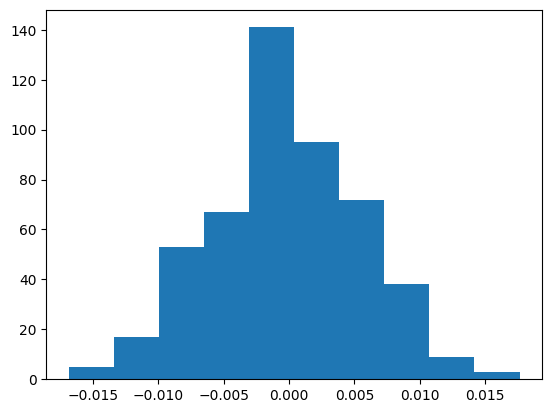

In [28]:
ms = (gp1_mean - gm1_mean) / 2/ 0.02 - 1 
plt.hist(ms)

In [30]:
ms.std() / jnp.sqrt(500) 


Array(0.0002525, dtype=float64)

In [56]:
ms.shape

(500,)

In [67]:
# bootstrap error over subsets 
rng_key2 = random.key(27)
boot = random.choice(rng_key2, jnp.arange(500), shape=(10000, 500), replace=True)
boot.shape

(10000, 500)

In [68]:
ms_errs = ms[boot].std(1) / jnp.sqrt(500)

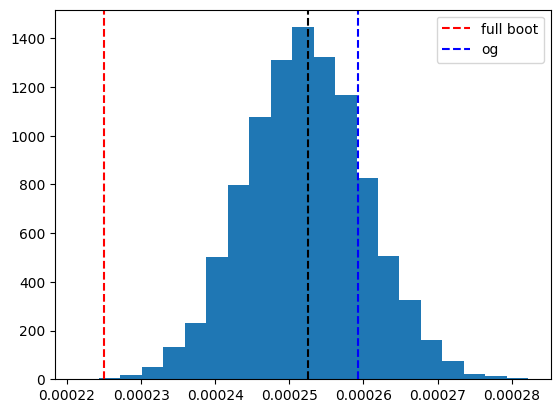

In [69]:
plt.hist(ms_errs, bins=21)
plt.axvline(ms.std() / jnp.sqrt(500) , ls='--', c='k')
plt.axvline(0.675 * 1e-3 / 3, ls='--', c='r', label='full boot')
plt.axvline(0.778 * 1e-3 / 3, ls='--', c='b', label='og')
plt.legend()

In [50]:
ms.std() / jnp.sqrt(500) - 2 * ms_errs.std()

Array(0.00021765, dtype=float64)

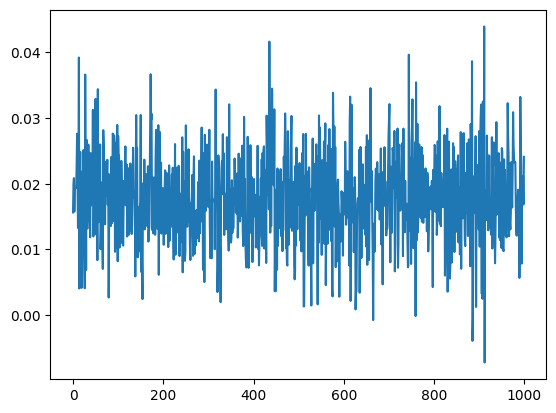

In [74]:
plt.plot(gp[21, :, 0]) # example convergence

# From expensive run

In [9]:
from bpd.io import load_dataset

In [10]:
ds1 = load_dataset("/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/subset_error_on_error_5155.npz")
ds2 = load_dataset("/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/subset_error_on_error_5156.npz")

dss = [ds1, ds2]
colors=['g', 'm']
seeds = [99, 101]

10 500
10 250


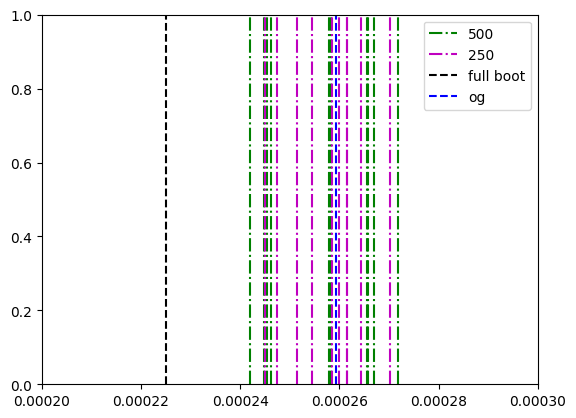

In [11]:
for ds, color, seed in zip(dss, colors, seeds):

    gp1s = ds['plus']['g1']
    gm1s = ds['minus']['g1']
    assert gp1s.shape[-1] >= 1000
    ms = (gp1s.mean(-1) - gm1s.mean(-1)) / 2/ 0.02 -1 

    n_exps = ms.shape[0]
    n_subsets = ms.shape[1]

    print(n_exps, n_subsets)
    ks = random.split(random.key(seed), n_exps)

    for ii in range(n_exps):
        k = ks[ii]
        boot = random.choice(k, jnp.arange(n_subsets), shape=(5000, n_subsets), replace=True)
        _ms = ms[ii]
        _err = _ms[boot].mean(1).std()

        if ii > 0:
            plt.axvline(_err , ls='-.', c=color)
        else: 
            plt.axvline(_err , ls='-.', c=color, label=n_subsets)


plt.axvline(0.675 * 1e-3 / 3, ls='--', c='k', label='full boot')
plt.axvline(0.778 * 1e-3 / 3, ls='--', c='b', label='og')
plt.xlim(0.00020, 0.00030)
plt.legend()


In [14]:
ms.shape

(10, 500)

In [15]:
# _rng_key = random.key(31)
# ks = random.split(_rng_key, 10)

# n_subsets = ms.shape[1]
# bins = jnp.linspace(0.00020, 0.00030, 51)
# for ii in range(10):
#     k = ks[ii]
#     _ms = ms[ii]
#     boot = random.choice(k, jnp.arange(n_subsets), shape=(5000, n_subsets), replace=True)
#     _ms_errs = _ms[boot].std(1) / jnp.sqrt(n_subsets)

#     plt.hist(_ms_errs, bins=bins, histtype='step')
#     plt.axvline(_ms.std() / jnp.sqrt(n_subsets) , ls='-.', c='k')


# plt.axvline(0.675 * 1e-3 / 3, ls='--', c='r', label='full boot')
# plt.axvline(0.778 * 1e-3 / 3, ls='--', c='b', label='og')
# plt.legend()

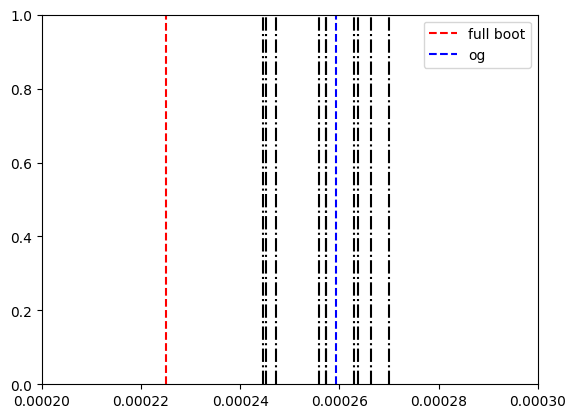

In [11]:
# compare with bootstrapping means to obtain error



# Use functions from descwl-shear-sims 

In [11]:
import numpy as np
import tqdm
from bpd.io import load_dataset

def _meas_m_c_cancel(pres, mres):

    x = np.mean(pres['g1'] - mres['g1'])/2
    m = x / 0.02 - 1

    c = np.mean(pres['g2'] + mres['g2'])/2
    
    return m, c


def _bootstrap_stat(d1, d2, func, seed, nboot=500):
    dim = d1.shape[0]
    rng = np.random.RandomState(seed=seed)
    stats = []
    for _ in tqdm.trange(nboot, leave=False):
        ind = rng.choice(dim, size=dim, replace=True)
        stats.append(func(d1[ind], d2[ind]))
    return stats


def _boostrap_m_c(pres, mres):
    m, c = _meas_m_c_cancel(pres, mres)
    bdata = _bootstrap_stat(pres, mres, _meas_m_c_cancel, 14324, nboot=2000)
    merr, cerr = np.std(bdata, axis=0)
    return m, merr, c, cerr


In [12]:
ds = load_dataset("/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/subset_error_on_error_5155.npz")

ds['plus']['g1'].shape

(10, 500, 1000)

In [ ]:
ms = [] 
m_errs = []

for ii in range(10):
    d1 = {k: ds['plus'][k][ii].median(1) for k in ds['plus']} # average over chain samples
    d2 = {k: ds['minus'][k][ii].mean(1) for k in ds['minus']}

    g1p = d1['g1']
    g2p = d1['g2']
    g1m = d2['g1']
    g2m = d2['g2']

    pres = np.array([(g1,g2) for g1, g2 in zip(g1p, g2p)], dtype=[('g1', 'f8'), ('g2', 'f8')])
    mres = np.array([(g1,g2) for g1, g2 in zip(g1m, g2m)], dtype=[('g1', 'f8'), ('g2', 'f8')])

    m, m_err, _ , _ = _boostrap_m_c(pres, mres)

    ms.append(m)
    m_errs.append(m_err)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [134]:
ms, m_errs

([np.float64(-0.00021032178617841346),
  np.float64(-0.000260003207478543),
  np.float64(-0.0004802099712646335),
  np.float64(-0.0003768166765194536),
  np.float64(-0.0005813633770331839),
  np.float64(-0.0003644942176836974),
  np.float64(-0.0001751149717429401),
  np.float64(-0.0001421482169524646),
  np.float64(-0.0005934560148986856),
  np.float64(-0.0002612694146687522)],
 [np.float64(0.00025485752997172014),
  np.float64(0.00025731955612536586),
  np.float64(0.0002443013243365266),
  np.float64(0.0002602005300483175),
  np.float64(0.0002760129892743122),
  np.float64(0.00025010822301364143),
  np.float64(0.0002482856920298858),
  np.float64(0.0002686832332327929),
  np.float64(0.00024485653095895367),
  np.float64(0.00026124582700510324)])

In [13]:
ds1 = load_dataset("/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/subset_error_on_error_5155.npz")
ds2 = load_dataset("/pscratch/sd/i/imendoza/data/cache_chains/exp72_51/subset_error_on_error_5156.npz")

dss = [ds1, ds2]
colors=['g', 'm']
seeds = [99, 101]

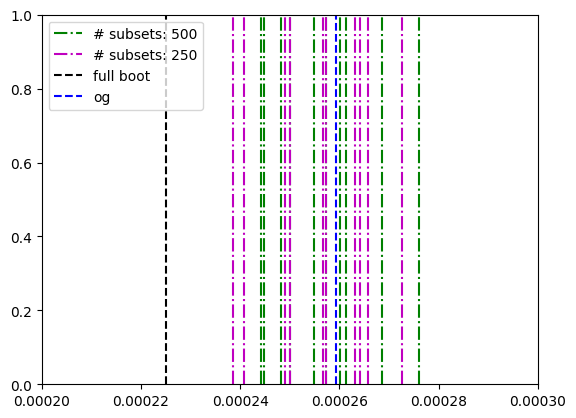

In [ ]:
for ds, color, seed in zip(dss, colors, seeds):

    n_exps = ds['plus']['g1'].shape[0]
    n_subsets = ds['plus']['g1'].shape[1]

    for ii in range(n_exps):
        d1 = {k: ds['plus'][k][ii].mean(1) for k in ds['plus']} # average over chain samples
        d2 = {k: ds['minus'][k][ii].mean(1) for k in ds['minus']}

        g1p = d1['g1']
        g2p = d1['g2']
        g1m = d2['g1']
        g2m = d2['g2']

        pres = np.array([(g1,g2) for g1, g2 in zip(g1p, g2p)], dtype=[('g1', 'f8'), ('g2', 'f8')])
        mres = np.array([(g1,g2) for g1, g2 in zip(g1m, g2m)], dtype=[('g1', 'f8'), ('g2', 'f8')])

        m, m_err, _ , _ = _boostrap_m_c(pres, mres)


        if ii > 0:
            plt.axvline(m_err , ls='-.', c=color)
        else: 
            plt.axvline(m_err , ls='-.', c=color, label=f'# subsets: {n_subsets}')


plt.axvline(0.675 * 1e-3 / 3, ls='--', c='k', label='full boot')
plt.axvline(0.778 * 1e-3 / 3, ls='--', c='b', label='og')
plt.xlim(0.00020, 0.00030)
plt.legend()


-0.00029837021678813525


-0.00032881053198474675


-0.0004397657672039479


-0.0004575062253333595


-0.0007615997212553349


-0.0002670566869906743


-0.0002616773581721743


-0.00010893712721249393


-0.0004122295538031562


-0.00030925282100624507


0.00019138492794179562


-0.0003936583899133428


-0.0006623566013512772


-0.0004843477296632148


-0.0003682868924245186


-0.0004198520110999526


-6.322427834237754e-05


-0.0007680125898122947


-0.00021287394034941176


-0.0003442272081426445


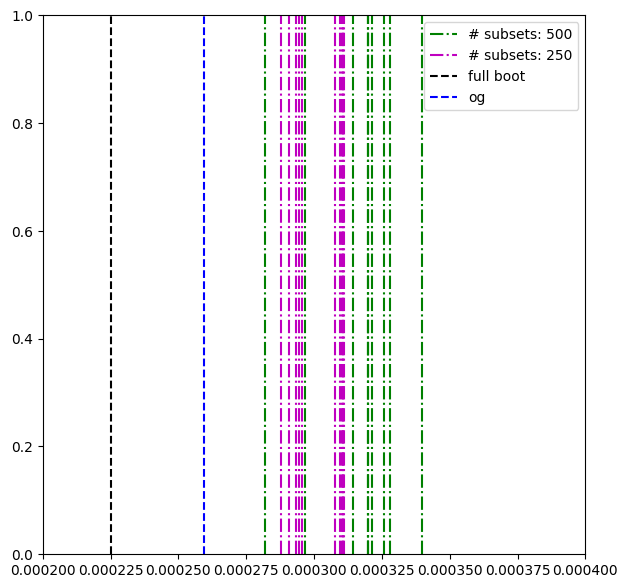

In [19]:
plt.figure(figsize=(7,7))

for ds, color, seed in zip(dss, colors, seeds):

    n_exps = ds['plus']['g1'].shape[0]
    n_subsets = ds['plus']['g1'].shape[1]

    for ii in range(n_exps):
        d1 = {k: np.median(ds['plus'][k][ii], axis=1) for k in ds['plus']} # average over chain samples
        d2 = {k: np.median(ds['minus'][k][ii], axis=1) for k in ds['minus']}

        g1p = d1['g1']
        g2p = d1['g2']
        g1m = d2['g1']
        g2m = d2['g2']

        pres = np.array([(g1,g2) for g1, g2 in zip(g1p, g2p)], dtype=[('g1', 'f8'), ('g2', 'f8')])
        mres = np.array([(g1,g2) for g1, g2 in zip(g1m, g2m)], dtype=[('g1', 'f8'), ('g2', 'f8')])

        m, m_err, _ , _ = _boostrap_m_c(pres, mres)
        print(m)


        if ii > 0:
            plt.axvline(m_err , ls='-.', c=color)
        else: 
            plt.axvline(m_err , ls='-.', c=color, label=f'# subsets: {n_subsets}')


plt.axvline(0.675 * 1e-3 / 3, ls='--', c='k', label='full boot')
plt.axvline(0.778 * 1e-3 / 3, ls='--', c='b', label='og')
plt.xlim(0.0002, 0.00040)
plt.legend()


In [18]:
m

np.float64(-0.0003442272081426445)

In [89]:
aa['a']

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [61]:
aa['a'].shape

(2, 10)